**Solving Sudoku Puzzle Using Neural Network**

The **classic sudoku** is a number placing puzzle game with a grid of **9 rows and 9 columns**, partly filled with **numbers 1..9** . We have to fill up the remaining positions such that each **row, columns and 3x3 sub grids** contains numbers 1..9, **without any repeatation**.

Here our **input** is an **image of sudoku** puzzle and we need to produce a corresponding **output image** by filling the remaining positions of the input with **valid** digits. The pipeline for the **solution** consists of the following steps.

1. Preprocess the input image and remove the background
2. Crop subregions containing digits from the grid
3. Predict numbers from image crops using neural network
4. Predict solution using neural network in an iterative manner
5. Verify the solution and plot the resuts on the input image

![picture](https://docs.google.com/drawings/d/e/2PACX-1vRMOwiXYg9cQ4OGfQxvuF2rxkJRHLOoJYJfAFnC2X_Ggxh2BACz1e4M2OV7h3iSjC8vzJp8SR9LP9sY/pub?w=921&h=606)



Initially **download** the sample images and tf.keras models for **digit recognition** and **sudoku solver**.

In [7]:
import requests
import zipfile
import os

# Use the new direct download URL
url = "https://dl.dropboxusercontent.com/s/69mg6m52y7uvzypo57wfd/sudoku_models.zip"
file_name = "sudoku_models.zip"

# Download the file
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(file_name, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("Download completed successfully.")
else:
    print(f"Failed to download file: Status code {response.status_code}")

# Verify if the file is indeed a ZIP file and extract it
if os.path.exists(file_name):
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall("./")
        print("File extracted successfully.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
else:
    print("Download failed or file not found.")


Failed to download file: Status code 403
File extracted successfully.


**Preprocess And Remove Background**

Crop, transform and save the **smallest square** region containing the puzzle.

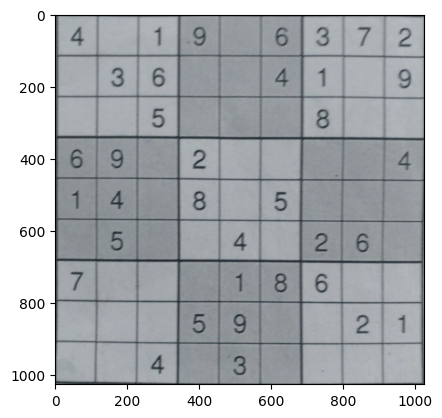

In [3]:
import cv2
import numpy as np
import math
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.util import view_as_blocks
from tensorflow.keras.models import load_model

# Read input sudoku image 
img =  cv2.imread("test/img_test_1/test_onestar_1.jpg")

# Preprocess the input image
img = cv2.resize(img,(1026,1026))

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgray =  cv2.GaussianBlur(imgray,(11,11),0)#cv2.medianBlur(imgray,3)

thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,5,2)

# Connect broken grid lines
kernel = np.array([0,1,0,1,1,1,0,1,0],dtype=np.uint8).reshape(3,3)
thresh = cv2.dilate(thresh, kernel,iterations = 2)

cv2.imwrite('thresh.jpg', thresh)

# Find the largest contour and approximate the polygonal curve
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt1 = max(contours, key = cv2.contourArea)
epsilon = 0.1*cv2.arcLength(cnt1,True)
cnt = cv2.approxPolyDP(cnt1,epsilon,True).squeeze()

# Sort co-ordinates in top-left raster order
cor_list=sorted(cnt.tolist() , key=lambda c: c[1]) # sort by y values
ord_list=sorted(cor_list[:2])+sorted(cor_list[2:]) # sort by x values

# Apply perspective transformation and get the  warped image
pts1 = np.float32(ord_list) #raster 
pts2 = np.float32([[0,0],[1026,0],[0,1026],[1026,1026]])
M = cv2.getPerspectiveTransform(pts1,pts2)
out_gry = cv2.warpPerspective(img,M,(1026,1026))
out_bin = cv2.warpPerspective(thresh,M,(1026,1026))

# Dilate the image to fill the cracks
kernel = np.array([0,1,0,1,1,1,0,1,0],dtype=np.uint8).reshape(3,3)
out_bin = cv2.dilate(out_bin, kernel,iterations = 1)

# Save the binary and grayscale outputs
cv2.imwrite('puzzle.jpg', out_gry)
cv2.imwrite('puzzle_bin.jpg', out_bin)

# Show the grayscale output image
plt.imshow(out_gry)

**Note:** The puzzle images must have been captured from a **flat** surface and it should not contain **additional marks** or patterns.

**Crop ROI Blocks**

Here, we use the previous **binarized and grayscale** versions of **output image**  for further processing.

* Divide the images into **9 rows and 9 columns** roughly along the grid patterns, such that each **block** containig the digits have **same size**.
* For each such block in the image we **crop and save the ROI**(81x81) containing the digits(or blank) from center, in grayscale mode. 
* Again, we crop the **largest square** containing the digits from their larger parent block and **resize** them to **32x32** size.
* If the ROI regions are **blank spaces** representing unfilled positions, we replace them with a **template** image of digit **zero**. 

Finally, save these entire batch of images as a **float numpy array**, in order and **plot** the results.

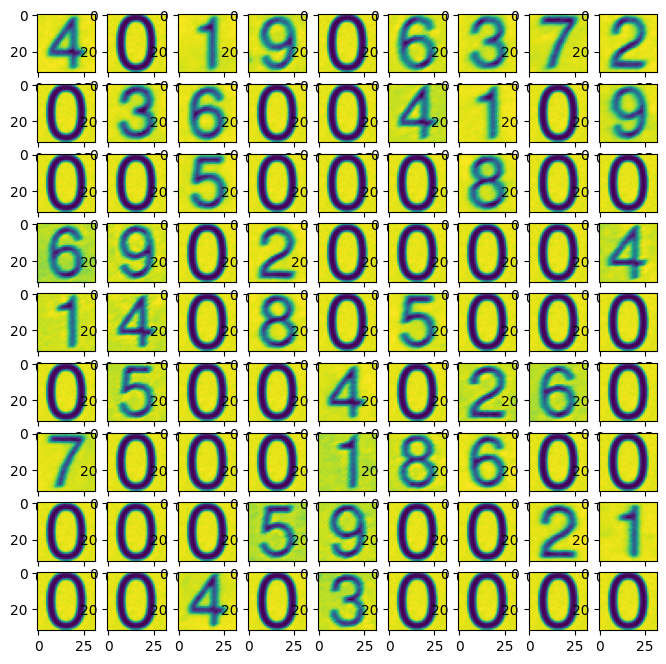

In [4]:

# Crop square ROI from the center of original grayscale image
def crop_center(bin, gry,cropx,cropy):
   
   y,x = bin.shape[0],bin.shape[1]
   startx = x//2-(cropx//2)
   starty = y//2-(cropy//2)    
    
   crop_bin = bin[starty:starty+cropy,startx:startx+cropx]
   crop_gry = gry[starty:starty+cropy,startx:startx+cropx]

   # Use binary image to find the largest contour
   contours, _ = cv2.findContours(crop_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
   zero=cv2.imread('images/zero_template.jpg', cv2.IMREAD_GRAYSCALE)
   
   # Check for blanks in the image
   if len(contours) == 0 or cv2.contourArea( max(contours, key = cv2.contourArea))<250:
     return zero

   # Get contour with maximum area
   cnt = max(contours, key = cv2.contourArea)
   x,y,w,h = cv2.boundingRect(cnt)
   d=(h-w)//2
   c=crop_gry.shape[0]
   ROI = crop_gry[y:y+h, max(0,x-d):min(c,x+w+d)] # Save grayscale image crops
   
   return ROI


# Get crop size for square blocks
imgheight=out_bin.shape[0]
imgwidth=out_bin.shape[1]
H,W = imgheight//9, imgwidth//9

# For each block crop roi and add them to list
sudokus=[]
gry=[]
for y in range(0,imgheight,H):
    for x in range(0, imgwidth, W):
        y1 = y + H
        x1 = x + W
        tiles_bin = out_bin[y:y+H,x:x+W]
        tiles_gry = cv2.cvtColor(out_gry[y:y+H,x:x+W], cv2.COLOR_BGR2GRAY)

        digits = crop_center(tiles_bin,tiles_gry,81,81)
        digits=cv2.resize(digits,(32,32),cv2.INTER_AREA)

        sudokus.append(digits/255.0)
  
# Create a float numpy array with 81 images from list
sudoku_numbers=np.float32(sudokus).reshape(81,32,32,1)

# Plot the images using matplotlib
fig=plt.figure(figsize=(8, 8))
columns = 9
rows = 9
for i in range(1, columns*rows +1):
    img = sudoku_numbers[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
plt.show()

**Predict Digits From Images**

* Load the **cnn model** trained on **SVHN dataset** and **predict** the output for the entire batch of **81 images**.
* The model **classifies** images of numbers **0 to 9** (i.e 10 class) and has **output shape**: (81, 10)
* Perform **argmax** on the last dimension of output and reshape them to **9x9** dimension.

In [8]:
# Predict the numbers from images, using neural network
model=load_model('models/digit_svhn-196-0.14.hdf5')
out=model.predict(sudoku_numbers)
puzzle=np.argmax(out,axis=-1).reshape((9,9))
print(puzzle)

3/3 [==============================] - 0s 8ms/step
[[4 0 1 9 0 6 3 7 2]
 [0 3 6 0 0 4 1 0 9]
 [0 0 5 0 0 0 8 0 0]
 [6 9 0 2 0 0 0 0 4]
 [1 4 0 8 0 5 0 0 0]
 [0 5 0 0 4 0 2 6 0]
 [7 0 0 0 1 8 6 0 0]
 [0 0 0 5 9 0 0 2 1]
 [0 0 4 0 3 0 0 0 0]]


**Note:** The model was trained on **entire svhn** dataset(train, test and extra) in **grayscale** mode. It acheived training **accuracy of 96 percent**.

**Solve Sudoku Puzzle**

The sudoku solver model takes as **input** an array of shape **9x9** representing the digits in the puzzle, from  the previous step.

* We **subtract mean and normalize** them to range **-0.5 to 0.5**, before feeding the entire batch as input to the model for **prediction**.

* In  each iteration we select an **element** in the output(9x9) with **maximum probability**(single) for the digits and fill those digits in the **corresponding positions** in the **input** array.

* We **repeat** the iterations with the new **modified input**, until there are **no unfilled locations** in the input (i.e no zeros).

Finally, print the **results** for each **iteration** and show the **final output** 

In [9]:
# Load the sudoku solver neural network
solver=load_model('models/sudoku_conv-20-0.10.hdf5')
solver.add(tf.keras.layers.Softmax())

'''
Sudoku Solver :-
The function takes a sudoku matrix of 9x9 with numbers 0...9 as input(i.e 'puzzle').
Zeros represents the blank spaces in the original puzzle.
Each iteration produces an output array of 9x9 with numbers 1...9 (i.e 'out').
For each such output array, 'maxp'(9x9) contains the corresponding probability values.
For each filled(non-zero) element in input array we set corresponding probability in 'maxp' o -1.
Now, find the maximum element in 'maxp' and set the corresponding positions of input with corresponding values from current output.
Repeat the iterations with modified input(i.e 'puzzle'), until all elements are filled (ie. no zeros).
'''
def sudoku_solve(puzzle, verbose=True):
  
  iter=0

  while 0 in puzzle :

    input_norm=(puzzle/9) - 0.5
    input_puzz=np.float32(input_norm.reshape(1,9,9,1))
    output_puzz=solver.predict(input_puzz)

    out=np.argmax(output_puzz,axis=-1).squeeze()+1
    maxp=np.max(output_puzz,axis=-1).squeeze()

    maxp[puzzle!=0]=-1.0

    indices=np.where(maxp==maxp.max())
    a,b = indices

    indices=(a[0],b[0]) # Select index of any one max element
    puzzle[indices]=out[indices]

    if verbose: 
      print("\n>>> Iteration :",iter,"\n")
      X,Y = indices
      iter = iter + 1
      print ((X, Y), " : ", out[indices] )

  return puzzle

solution=sudoku_solve(puzzle.copy())

print("\n======SOLUTION======\n")
print(solution)

1/1 [==============================] - 0s 242ms/step

>>> Iteration : 0 

(0, 1)  :  8
1/1 [==============================] - 0s 90ms/step

>>> Iteration : 1 

(0, 4)  :  5
1/1 [==============================] - 0s 58ms/step

>>> Iteration : 2 

(1, 0)  :  2
1/1 [==============================] - 0s 72ms/step

>>> Iteration : 3 

(1, 3)  :  7
1/1 [==============================] - 0s 103ms/step

>>> Iteration : 4 

(1, 4)  :  8
1/1 [==============================] - 0s 59ms/step

>>> Iteration : 5 

(1, 7)  :  5
1/1 [==============================] - 0s 64ms/step

>>> Iteration : 6 

(2, 0)  :  9
1/1 [==============================] - 0s 88ms/step

>>> Iteration : 7 

(2, 1)  :  7
1/1 [==============================] - 0s 71ms/step

>>> Iteration : 8 

(2, 4)  :  2
1/1 [==============================] - 0s 99ms/step

>>> Iteration : 9 

(2, 7)  :  4
1/1 [==============================] - 0s 105ms/step

>>> Iteration : 10 

(2, 8)  :  6
1/1 [==============================] - 0s 110ms/st

**Note:** The model was trained on a dataset with **10 million** sudoku puzzles. It  achieved a training **accuracy of 96 percent**.

**Verify And Plot Solution**

Check the solution to see if it passes all the **test cases** for a correct solution.
* Verify if each **row, column and block** contains numbers **0 to 9** in the final solution.(verification)
* Also check if the **original digits** in the inital input were **modified** in the final solution.(validation)
* Plot the new **digits** from solution in their corresponding positions on the input **grayscale image**.

Correct solution


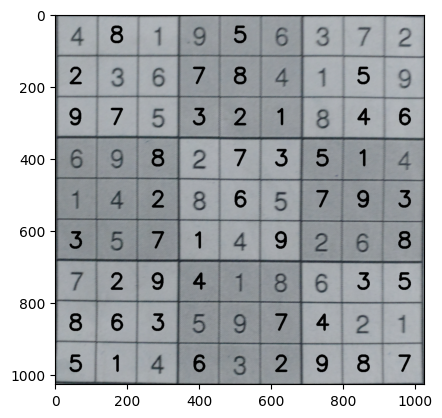

In [10]:
# Verify the sudoku solution
def check_sudoku(puzzle, solution):
  
  # Verify if fixed non-zero elements of input has changed
  for i in range(81):
     if puzzle.flatten()[i] != 0:
       if puzzle.flatten()[i] != solution.flatten()[i]:
         print("Wrong solution: puzzle modified ")
         return 0
        
  blocks=view_as_blocks(solution, (3, 3)).reshape(9,9)
  nos=np.arange(1,10)

  # Check uniqueness of rows, columns and blocks in solution
  for i in range(9):
    if not np.array_equal(np.unique(solution[i]), nos):
       print("Wrong solution") # rows mismatch
       return 0
    elif not np.array_equal(np.unique(solution.T[i]), nos):
       print("Wrong solution") # columns mismatch
       return 0
    elif not np.array_equal(np.unique(blocks[i]), nos):
       print("Wrong solution") # blocks mismatch
       return 0
  
  print("Correct solution")
  return 1

check_sudoku(puzzle.copy(), solution.copy())

# Plot the results over the original image
def show_output(puzzle, solution, sudoku):

  for i in range(9):
    for j in range(9):
      pos=(37+114*j, 77+114*i)
      if puzzle[i,j] == 0:
        cv2.putText(sudoku,str(solution[i,j]),pos, cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)

  plt.imshow(sudoku)

show_output(puzzle.copy(),solution.copy(),out_gry.copy())

**Testing Sudoku Solver Model**

The test dataset consists of **30 puzzles** from website: **https://1sudoku.com**  and **30** random puzzles from **newspapers**. They mostly contain **difficulties** ranging from **easy to medium**.

In [11]:
import numpy as np

# Load the two test datasets
x1=np.load('test/raw_test_1/test_puzzles_1.npy')
y1=np.load('test/raw_test_1/test_solutions_1.npy')

x2=np.load('test/raw_test_2/test_puzzles_2.npy')
y2=np.load('test/raw_test_2/test_solutions_2.npy')

# Combine the two test datasets
x=np.concatenate([x1,x2], axis=0)
y=np.concatenate([y1,y2], axis=0)

# Evaluate the models using test dataset
def evaluate(puzzle, solution):
  total=len(puzzle)
  correct=0
  for i in range(len(puzzle)):
    puzz=puzzle[i]
    solution=sudoku_solve(puzz.reshape(9,9), verbose=False)
    print("\nPuzzle Number: ",i)
    correct += check_sudoku(puzz, solution)

  print("\nTotal: {}, Correct: {}".format(total, correct))  
    

evaluate(x.copy(),y.copy())

1/1 [==============================] - 0s 109ms/step

Puzzle Number:  0
Correct solution
1/1 [==============================] - 0s 92ms/step

Puzzle Number:  1
Correct solution
1/1 [==============================] - 0s 52ms/step

Puzzle Number:  2
Correct solution
1/1 [==============================] - 0s 52ms/step

Puzzle Number:  3
Correct solution
1/1 [==============================] - 0s 56ms/step

Puzzle Number:  4
Correct solution
1/1 [==============================] - 0s 51ms/step

Puzzle Number:  5
Correct solution
1/1 [==============================] - 0s 85ms/step

Puzzle Number:  6
Wrong solution
1/1 [==============================] - 0s 48ms/step

Puzzle Number:  7
Wrong solution
1/1 [==============================] - 0s 52ms/step

Puzzle Number:  8
Wrong solution
1/1 [==============================] - 0s 55ms/step

Puzzle Number:  9
Correct solution
1/1 [==============================] - 0s 48ms/step

Puzzle Number:  10
Wrong solution
1/1 [==============================] -